In [71]:
import keras
import cv2
import h5py
from collections import Counter
np.random.seed(12345)
from keras import backend as K
from keras import models
from keras.utils import np_utils
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
from keras.layers.normalization import BatchNormalization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report

In [2]:
np.random.seed(12345)

In [3]:
def cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height):
    """ 
    座標を指定することで、画像から矩形領域をカットする関数
    left_x : 左上のx座標
    upper_y : 左上のy座標
    window_width : 矩形の幅a
    window_height : 矩形の高さ
    """
    # 窓画像の左上座標
    x, y = left_x, upper_y
    # 窓画像の幅・高さ
    w, h = window_width, window_height
    # 入力画像から窓画像を切り取り
    roi = img[y:y+h, x:x+w]    
    return roi

In [4]:
# パッチのサイズの情報
window_width = 100
window_height = 100   
slide_width = 10

In [5]:
# それぞれの画像について腫瘍情報のテーブルを作る
#UT007に関してはもう一度みる必要あり
pic_info = pd.DataFrame({
                'patient_id' :        ['UT001', 'UT001', 'UT001', 'UT010', 'UT010', 'UT010',  'UT010', 'UT003', 'UT003', 'UT003', 'UT007', 'UT007', 'UT007', 'UT008', 'UT008', 'UT008', 'UT009', 'UT009', 'UT009','UT011','UT011','UT011'],
                'patient_sub_height': [  '100',   '200',   '300',   '900',  '1000',  '1100',   '1200',  '1300',  '1400',  '1500',   '700',   '800',   '900',   '600',   '700',   '800',  '1500',  '1600',  '1700',  '600',  '700',  '800'],
                'patient_sub_speed':  [ '1480',  '1480',  '1480',  '1510',  '1510',  '1510',   '1510',  '1480',  '1480',  '1480',  '1523',  '1523',  '1523',  '1521',  '1521',  '1521',  '1518',  '1518',  '1518', '1523', '1523', '1523'],
                'tumor_left_x' :      [    195,     201,     198,     310,     310,     310,     310,      295,     290,    290,      180,     200,     195,     200,     200,     200,     132,     132,     127,    170,   175,     172],
                'tumor_upper_y' :     [    205,     208,     200,     225,     225,     225,     230,      300,     298,    300,      230,     250,     240,     220,     220,     220,     270,     270,     270,    245,   250,     253],
                'tumor_width' :       [     50,      50,      50,      70,      50,      45,      45,       50,      50,     50,       80,      60,      70,      70,      70,      70,      50,      50,      50,     55,    55,      45],
                'tumor_height' :      [     45,      45,      45,      45,      70,      50,      50,       35,      30,     40,       80,      60,      70,      40,      40,      40,      55,      55,      55,     55,    55,      45],
                'default_left_x' :    [    100,     100,     100,     150,    150,      150,     150,      100,     100,    100,      100,     100,     100,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'default_upper_y' :   [    100,     100,     100,     100,    100,      100,     100,      100,     100,    100,      200,     200,     200,     100,     100,     100,     100,     100,      100,    100,   100,    100],
                'max_left_x' :        [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      220,     220,     220,     340,     340,     340,     340,     340,      340,    250,   250,    250],
                'max_upper_y' :       [    340,     340,     340,     340,    340,      340,     340,      340,     340,    340,      280,     280,     280,     240,     340,     340,     340,     340,      340,    300,   300,    300],
                'file_path' : []
                }, index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [6]:
sample_size = len(pic_info)  # 2以上である必要あり

In [7]:
j = 0
X = []

patch = []
p_id = []
label = []
x_y_label = []

for j in range(0, sample_size, 1):

    patient_id = pic_info['patient_id'][j]
    tumor_left_x = pic_info['tumor_left_x'][j]
    tumor_upper_y = pic_info['tumor_upper_y'][j]
    tumor_width = pic_info['tumor_width'][j]
    tumor_height = pic_info['tumor_height'][j]
    default_left_x = pic_info['default_left_x'][j]
    default_upper_y = pic_info['default_upper_y'][j]
    max_left_x = pic_info['max_left_x'][j]
    max_upper_y = pic_info['max_upper_y'][j]
    file_path = pic_info['file_path'][j]
    
    img = cv2.imread(file_path)       

    # 写真の中の(100, 100) から (440, 440)までの間でパッチを作る
    # パッチの大きさは100 * 100にする
    # スライド幅は20ずつにする
    # sliding windowにより作られるパッチの数は (340 - 100) / 20 * (340 - 100) / 20 = 144個
    # それが5つぶんで 144 * 5 = 720個
            
    i = 0

    for left_x in range(default_left_x, max_left_x, slide_width):
        for upper_y in range(default_upper_y, max_upper_y, slide_width):
            img_patch = cut_window_by_coordinate(img, left_x, upper_y, window_width, window_height)
            
            X.append(img_to_array(img_patch/255.0))
            
            # 癌が含まれているかの判定 完全に領域を含んでいる場合のみ検出する
            if tumor_left_x >= left_x and tumor_left_x + tumor_width <= left_x + window_width and tumor_upper_y >= upper_y and tumor_upper_y + tumor_height <= upper_y + window_height:
                contains_tumor = 1 
            else: contains_tumor = 0
            
            # 角フラグを立てる
            if left_x == default_left_x or left_x == max_left_x - slide_width:
                corner_flag = 1
            else: corner_flag = 0
            
            # patch_idの付与 一応
            patch_id = patient_id + str(left_x) + str(upper_y)      
            
            #画像とlabelの対応を確実に行う
            x_y_set = (img_to_array(img_patch/255.0), contains_tumor, patient_id, patch_id)
            
            p_id.append(patient_id)
            patch.append(patch_id)
            label.append(contains_tumor)
            x_y_label.append(x_y_set)
            
            i += 1

In [18]:
patient = "UT001"

In [19]:
train_cancer=[]
train_not_cancer=[]
test_cancer=[]
test_not_cancer=[]

for i in range(len(x_y_label)):
    if x_y_label[i][1] == 0 and x_y_label[i][2] != patient :
        train_not_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 1 and x_y_label[i][2] != patient :
        train_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 0 and x_y_label[i][2] == patient :
        test_not_cancer.append(x_y_label[i])
    elif x_y_label[i][1] == 1 and x_y_label[i][2] == patient :
        test_cancer.append(x_y_label[i])

#ラベルの比率合わせ
train_length_min = min([len(train_cancer), len(train_not_cancer)])
test_length_min = min([len(test_cancer), len(test_not_cancer)])

train_cancer = random.sample(train_cancer, train_length_min)
train_not_cancer = random.sample(train_not_cancer, train_length_min)
test_cancer = random.sample(test_cancer, test_length_min)
test_not_cancer = random.sample(test_not_cancer, test_length_min) 

train_cancer.extend(train_not_cancer)
test_cancer.extend(test_not_cancer)

In [20]:
print(len(train_cancer))
print(len(train_not_cancer))
print(len(test_cancer))
print(len(test_not_cancer))

996
498
170
85


In [21]:
X_train, Y_train, _, _, = list(zip(*train_cancer))
X_test, Y_test, _, _, = list(zip(*test_cancer))

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
                                                          
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

from keras.utils.np_utils import to_categorical
x_train = np.array(X_train).astype('float32')
y_train = to_categorical(Y_train, 2)

x_test = np.array(X_test).astype('float32')
y_test = to_categorical(Y_test, 2)

In [31]:
len(x_train)

996

In [22]:
img_rows, img_cols = 100, 100

In [23]:
# shapeの調整
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 1)

In [24]:
val_x_train, val_x_test, val_y_train, val_y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=123)

In [25]:
n_filter = 32
n_filter2 = 64
n_filter3 = 128

size_filter = 3
size_filter2 = 1
size_filter3 = 5
size_pool = 2
n_hidden = 512
n_label = 2

model = Sequential()

model.add(Conv2D(n_filter,(size_filter, size_filter), padding='same',
                 input_shape=X_train.shape[1:], activation = 'relu'))
model.add(Conv2D(n_filter,(size_filter, size_filter), activation = 'relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter2, (size_filter, size_filter), padding='same', activation = 'relu'))
#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter2, (size_filter, size_filter), activation = 'relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
#model.add(Dropout(0.25))

model.add(Conv2D(n_filter3, (size_filter, size_filter), padding='same', activation = 'relu'))

#model.add(BatchNormalization(axis=-1))
model.add(Conv2D(n_filter3, (size_filter, size_filter), activation = 'relu'))
#model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(size_pool, size_pool)))
model.add(Flatten())
model.add(Dense(n_hidden))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_label))       # クラスは2個
model.add(Activation('sigmoid'))

### UT007

In [15]:
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 537 samples, validate on 537 samples
Epoch 1/20
537/537 [==============================] - 86s 159ms/step - loss: 0.6977 - acc: 0.5214 - val_loss: 0.7156 - val_acc: 0.5009
Epoch 2/20
537/537 [==============================] - 80s 148ms/step - loss: 0.6674 - acc: 0.5214 - val_loss: 0.5940 - val_acc: 0.6965
Epoch 3/20
537/537 [==============================] - 86s 160ms/step - loss: 0.6368 - acc: 0.6257 - val_loss: 0.6314 - val_acc: 0.6369
Test loss: 0.6568957282149274
Test accuracy: 0.6086956534696661


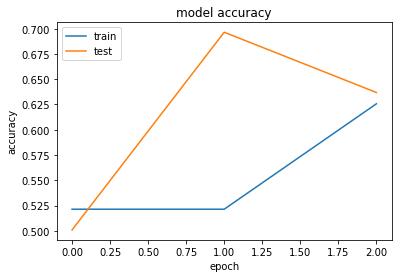

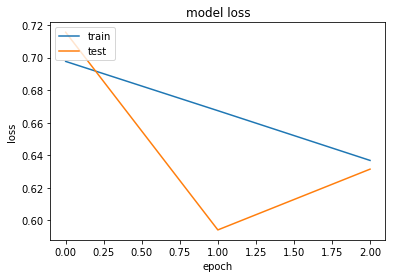

In [16]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
classes = model.predict_classes(x_test)

In [18]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[10 36]
 [ 0 46]]
accuracy :  0.6086956521739131
recall:  1.0


In [19]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[10 36]
 [ 0 46]]
             precision    recall  f1-score   support

          0       1.00      0.22      0.36        46
          1       0.56      1.00      0.72        46

avg / total       0.78      0.61      0.54        92



### UT011

In [35]:
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 497 samples, validate on 497 samples
Epoch 1/20
497/497 [==============================] - 69s 139ms/step - loss: 0.7165 - acc: 0.5050 - val_loss: 0.6828 - val_acc: 0.4970
Epoch 2/20
497/497 [==============================] - 65s 131ms/step - loss: 0.6281 - acc: 0.5835 - val_loss: 0.5291 - val_acc: 0.7243
Epoch 3/20
497/497 [==============================] - 64s 128ms/step - loss: 0.5863 - acc: 0.6519 - val_loss: 0.5033 - val_acc: 0.7626
Epoch 4/20
497/497 [==============================] - 65s 131ms/step - loss: 0.5261 - acc: 0.7284 - val_loss: 0.4874 - val_acc: 0.7525
Epoch 5/20
497/497 [==============================] - 71s 143ms/step - loss: 0.5270 - acc: 0.7203 - val_loss: 0.5770 - val_acc: 0.7626
Test loss: 0.6092193951440412
Test accuracy: 0.7325581395348837


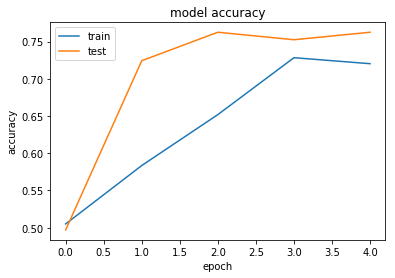

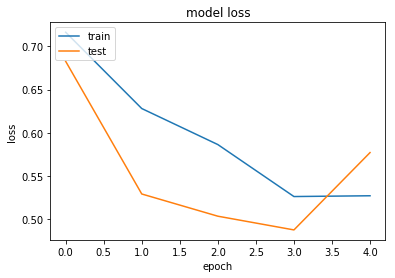

In [36]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
classes = model.predict_classes(x_test)

In [38]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[43 43]
 [ 3 83]]
accuracy :  0.7325581395348837
recall:  0.9651162790697675


In [39]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[43 43]
 [ 3 83]]
             precision    recall  f1-score   support

          0       0.93      0.50      0.65        86
          1       0.66      0.97      0.78        86

avg / total       0.80      0.73      0.72       172



In [26]:
print('model')
print(model.summary())

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 23, 128)       73856     
____

In [75]:
np.random.seed(12345)
loss='categorical_crossentropy'
#optimizer = optimizers.SGD(lr=0.01, momentum = 0.9, )
#opt = TFOptimizer(YFOptimizer())
optimizer = "Adam"
batch = 64
epoch = 20

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

#　Tensor Boardのcallbackを作成
from keras.callbacks import TensorBoard
tbcb = TensorBoard(log_dir = './graph',
                 histogram_freq = 0, write_graph = True)

# historyに学習履歴を取得
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

#validation_data にtest_dataを用いるのは良くない

history = model.fit(val_x_train, val_y_train, batch_size=batch, epochs=epoch,
                   validation_data = (val_x_test, val_y_test), verbose=1,
                   callbacks = [es_cb])


# モデルの保存
#from keras.models import model_from_json
#model_json=model.to_json()
#with open("model.json",mode='w') as f:
#    f.write(model_json)
    
# 学習済みの重みを保存
#model.save_weights("weights.hdf5")

# 学習履歴を保存
#import pickle
#with open("history.pickle",mode='wb') as f:
#    pickle.dump(history.history,f)
    
#score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 498 samples, validate on 498 samples
Epoch 1/20
498/498 [==============================] - 69s 138ms/step - loss: 0.4284 - acc: 0.8112 - val_loss: 0.5320 - val_acc: 0.7671
Epoch 2/20
498/498 [==============================] - 67s 136ms/step - loss: 0.3953 - acc: 0.8133 - val_loss: 0.4992 - val_acc: 0.7631
Epoch 3/20
498/498 [==============================] - 58s 117ms/step - loss: 0.3926 - acc: 0.8133 - val_loss: 0.5200 - val_acc: 0.7671
Test loss: 0.4034660633872537
Test accuracy: 0.8117647051811219


In [76]:
classes = model.predict_classes(x_test)

In [77]:
confmat = confusion_matrix(y_true=Y_test, y_pred=classes)
print(confmat)
print('accuracy : ', accuracy_score(Y_test, classes))
print('recall: ', recall_score(Y_test, classes))

[[58 27]
 [ 8 77]]
accuracy :  0.7941176470588235
recall:  0.9058823529411765


In [40]:
test_seikai_label = (np.argmax(y_test,axis = 1) ).reshape(-1,1)
print(confusion_matrix(test_seikai_label, classes))
print(classification_report(test_seikai_label, classes))

[[59 26]
 [ 9 76]]
             precision    recall  f1-score   support

          0       0.87      0.69      0.77        85
          1       0.75      0.89      0.81        85

avg / total       0.81      0.79      0.79       170



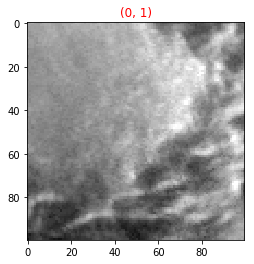

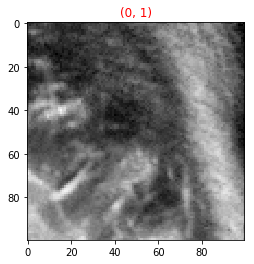

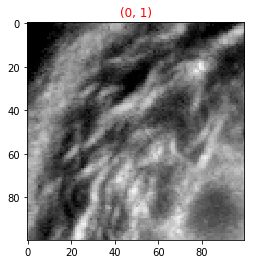

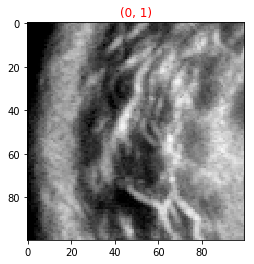

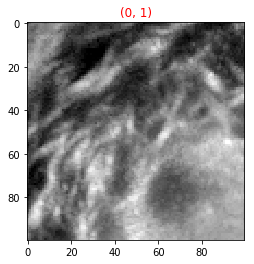

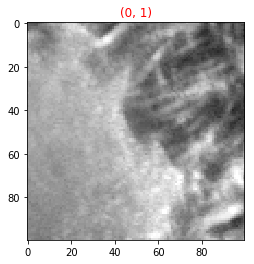

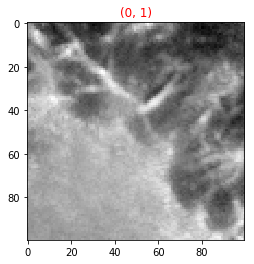

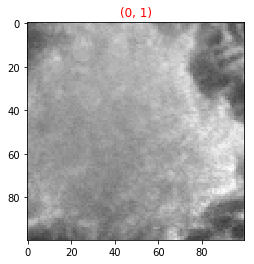

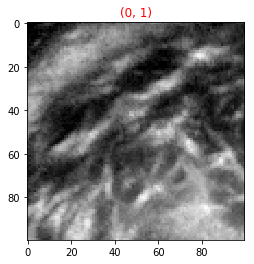

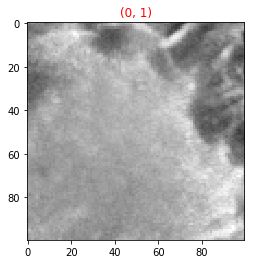

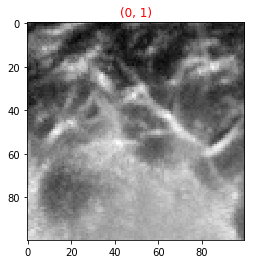

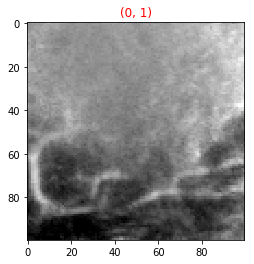

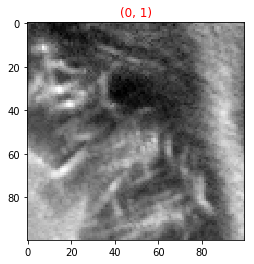

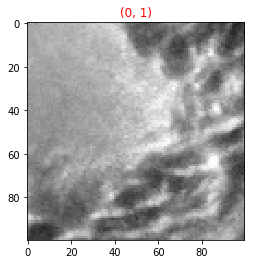

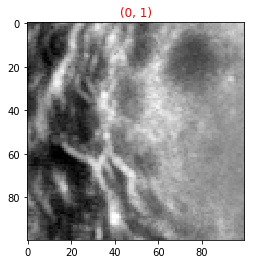

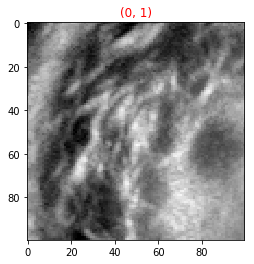

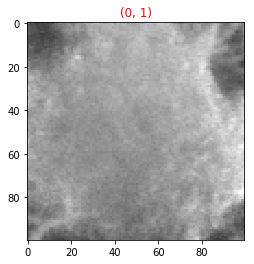

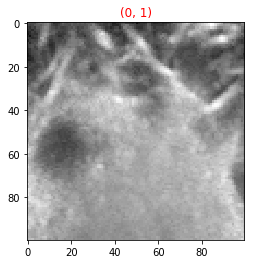

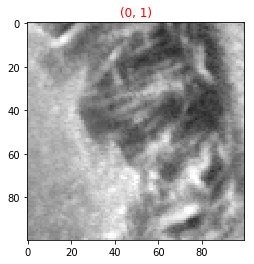

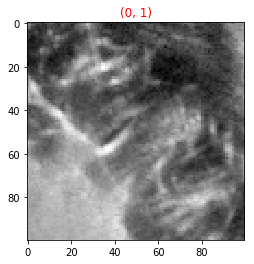

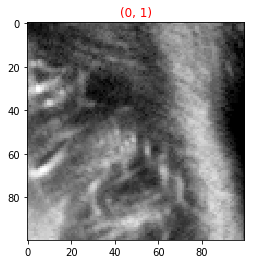

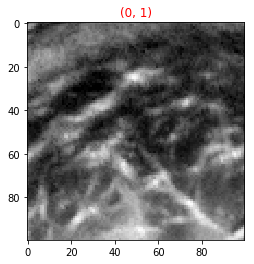

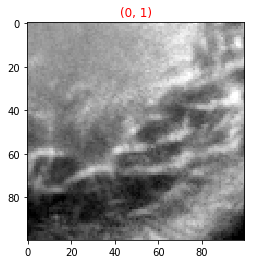

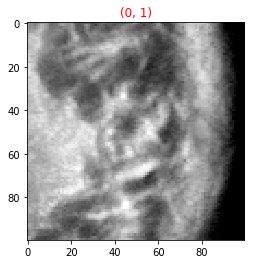

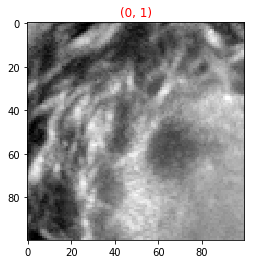

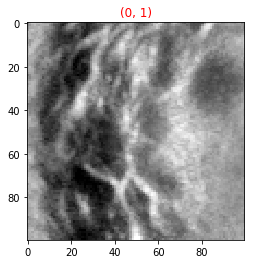

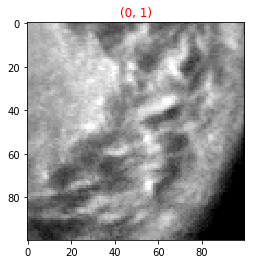

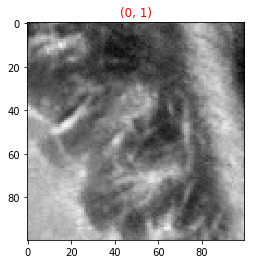

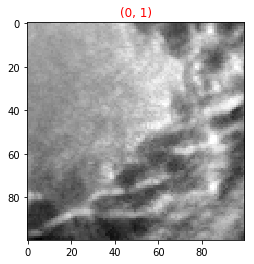

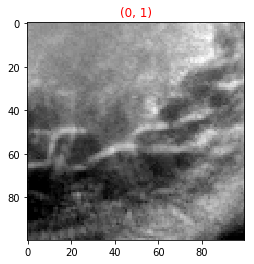

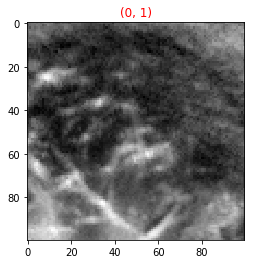

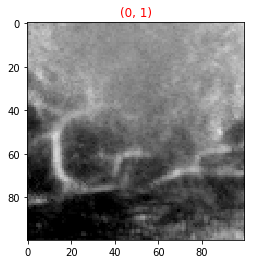

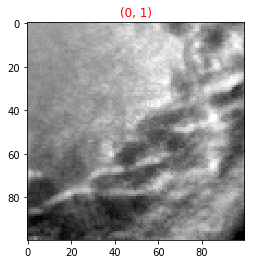

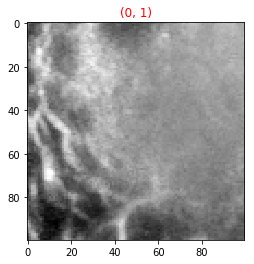

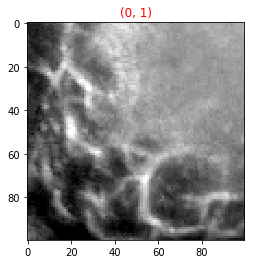

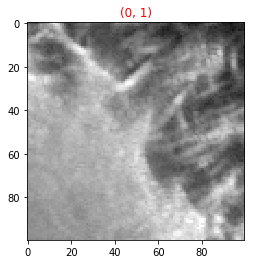

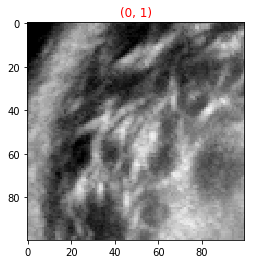

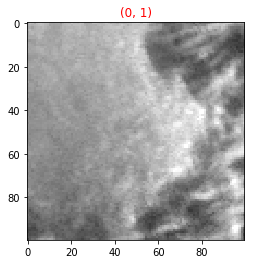

In [20]:
diff = test_seikai_label.reshape(-1,) - classes
diff_num = np.count_nonzero(diff)
diff_list = np.where(diff != 0)



for i in range(diff_num):
    plt.imshow(x_test[diff_list][i], 'gray')
    plt.title((Y_test[diff_list][i], classes[diff_list][i]) , color="red")
    plt.show()

In [75]:
model.layers

In [106]:
layer_outputs = [layer.output for layer in model.layers[:16]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
select_img = x_test[0]

In [107]:
img = np.expand_dims(select_img, axis=0)

In [108]:
activations = activation_model.predict(img)

In [109]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 100, 100, 32)


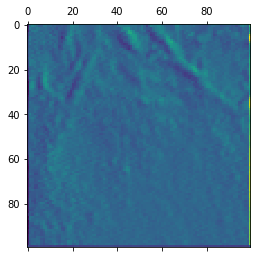

In [110]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

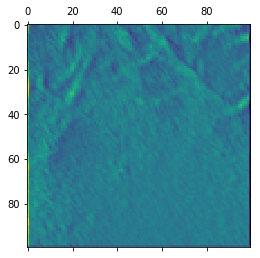

In [111]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [78]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:16]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

NameError: name 'activations' is not defined

In [113]:
preds = model.predict(img)
np.argmax(preds[0])

1

In [114]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 1]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('conv2d_6')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([img])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

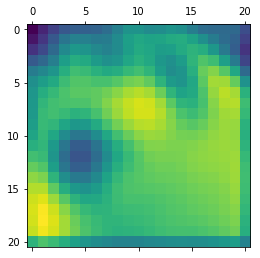

In [116]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [117]:
import cv2

# We use cv2 to load the original image
#img = cv2.imread('./data/all_data/tumor/P_UT001_20161226_153444_100_speed1480_GCF010_comp8.bmp')

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (select_img.shape[1], select_img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + select_img

In [118]:
heatmap.shape

(100, 100, 3)

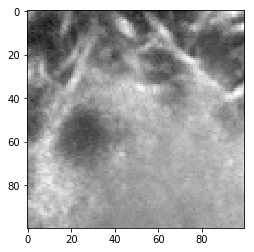

In [119]:
plt.imshow(select_img)
plt.show()

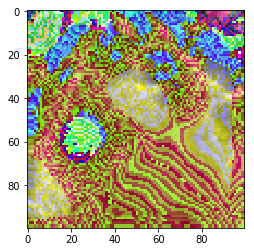

In [120]:
plt.imshow(superimposed_img)
plt.show()

In [69]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

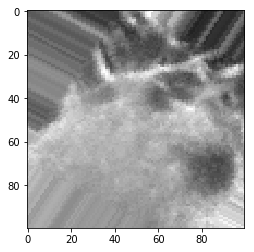

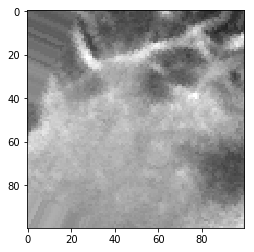

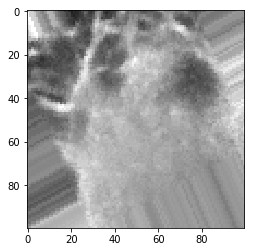

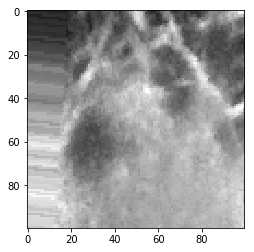

In [70]:
from keras.preprocessing import image

x = X_test[10]
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()